# Td Idf

In [2]:
import numpy as np
import pandas as pd
import config
import jupyter_service
import sys
import matplotlib.pyplot as plt
from dbcontext import Context
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.display.float_format = '{:.2f}'.format
print(sys.version, np.__version__, pd.__version__, config.version)

3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)] 2.0.2 2.2.3 0.1.0.Alpha


In [3]:
context = Context()
context.create(echo=False)
service = jupyter_service.JupyterService(context)
print(config.connection_string)

postgresql://postgres:sa@localhost:5432/yt1


In [12]:
sql = """SELECT avg(count) as average, PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY count) as median_, PERCENTILE_CONT(0.25) WITHIN GROUP(ORDER BY count) as quartile, PERCENTILE_CONT(0.1) WITHIN GROUP(ORDER BY count) as decile, PERCENTILE_CONT(0.01) WITHIN GROUP(ORDER BY count) as percentile FROM topic where source='tdidf' and count > 1"""
df = service.get_by_sql(sql)
avg=51
median=13
percentile=2
nb_topic=588
nb_form=15854
df

,average,median_,quartile,decile,percentile
0,51.24,13.00,5.00,3.00,2.00


Most used topics by forms

In [4]:
sql = """select topic.label, sum(form_topic.score) as nb_form from topic
join form_topic on form_topic.topic_id=topic.id
where source='tdidf'
group by topic.id
order by nb_form desc"""
df = service.get_by_sql(sql)
df.head(10)

,label,nb_form
0,peace,787.32
1,happiness,579.54
2,happy,469.36
3,world,417.12
4,success,339.21
5,life,334.16
6,good,333.49
7,wish,323.46
8,health,297.94
9,better,297.60


Lemas

In [5]:
topic = "peace"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)


,topic_label,lema_label,count
0,peace,peace,3339
1,peace,peace,2802
2,peace,peaceful,412
3,peace,world_peace,350
4,peace,world_peace,322
5,peace,peaceful,209
6,peace,have_peace,52
7,peace,peacefully,47
8,peace,more_peaceful,40
9,peace,more_peace,37


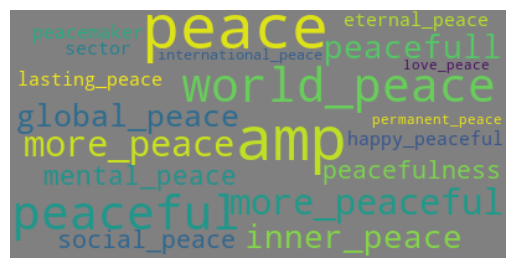

In [6]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
empathy_category="empathy"

Empathy Negative Score

In [13]:
sql = f"""select topic.id, topic.label, sum(form_topic.score) as nb_neg_form, sub_topic.nb_form, power(sum(form_topic.score)::float,2)/sub_topic.nb_form as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, sum(form_topic.score) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='tdidf'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > {avg}
) sub_topic on sub_topic.id = topic.id
where source='tdidf'
and stat.{empathy_category}_category=0
and form_topic.question_nb=12
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {median}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)


,id,label,nb_neg_form,nb_form,ratio
0,9794,rich,7.34,111.84,0.48
1,9090,money,8.85,168.42,0.46
2,9800,good,10.63,333.49,0.34
3,9106,better,9.52,297.60,0.30
4,9073,peace,14.90,787.32,0.28
5,9712,success,9.72,339.21,0.28
6,9109,world,10.08,417.12,0.24
7,9100,wish,8.42,323.46,0.22
8,9655,person,5.52,143.05,0.21
9,9593,successful,7.57,276.46,0.21


In [15]:
topic = "rich"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
order by lema.count desc"""
df = service.get_by_sql(sql)
df.head(10)

,topic_label,lema_label,count
0,rich,rich,314
1,rich,rich,52
2,rich,become_rich,28
3,rich,being_rich,18
4,rich,richest,16
5,rich,richest,10
6,rich,richness,4
7,rich,richness,3
8,rich,very_rich,3
9,rich,affluence,2


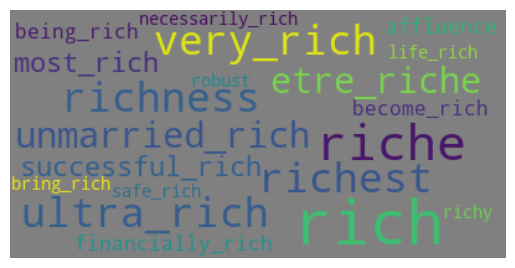

In [16]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

PD Positive Score

In [20]:
sql = f"""select topic.id, topic.label, sum(form_topic.score) as nb_pos_form, sub_topic.nb_form, power(sum(form_topic.score)::float,2)/sub_topic.nb_form as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, sum(form_topic.score) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='tdidf'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > {avg}
) sub_topic on sub_topic.id = topic.id
where source='tdidf'
and form_topic.question_nb=12
and stat.{empathy_category}_category=2
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {median}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)

,id,label,nb_pos_form,nb_form,ratio
0,9073,peace,354.53,787.32,159.64
1,9796,happiness,270.68,579.54,126.43
2,9100,wish,187.29,323.46,108.45
3,9089,happy,215.32,469.36,98.78
4,9109,world,201.17,417.12,97.02
5,9790,love,130.56,233.56,72.99
6,9062,life,146.86,334.16,64.54
7,9106,better,133.40,297.60,59.79
8,9712,success,141.97,339.21,59.42
9,9800,good,135.65,333.49,55.17


In [222]:
topic = "peace"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)

,topic_label,lema_label,count
0,peace,peace,2802
1,peace,world_peace,350
2,peace,peaceful,209
3,peace,more_peace,37
4,peace,inner_peace,25
5,peace,quiet,21
6,peace,secure,16
7,peace,peacefull,16
8,peace,serenity,14
9,peace,more_peaceful,13


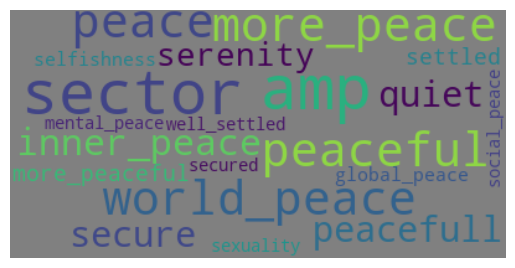

In [223]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Low Noise
857 topics
Low noise = 8
Very low = 1


In [22]:
low_noise = median
very_low_noise = percentile
thresold = nb_form / 1000
thresold, low_noise, very_low_noise

(15.854, 13, 2)

In [61]:
sql = f"""select topic.id, topic.label, sum(form_topic.score) as nb_neg_form, sub_topic.nb_form, log(power(sum(form_topic.score)::float,2)/power(2.7, sub_topic.nb_form)) as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, sum(form_topic.score) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='tdidf'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > 1 and count(form_topic.id) < {avg}
) sub_topic on sub_topic.id = topic.id
where source='tdidf'
and form_topic.question_nb=12
and stat.{empathy_category}_category=0
group by topic.id, sub_topic.nb_form
having count(form_topic.id) >= {very_low_noise}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)

,id,label,nb_neg_form,nb_form,ratio
0,9860,fund,0.98,1.51,-0.67
1,11896,programmer,1.10,2.43,-0.97
2,11107,wrong,0.91,2.69,-1.24
3,9197,cooperate,1.16,3.63,-1.44
4,11626,thanks,1.59,4.47,-1.53
5,13440,organizations,0.44,2.17,-1.65
6,13342,pleasure,1.13,4.36,-1.78
7,10096,foreign,0.49,2.73,-1.80
8,12378,affect,0.75,3.60,-1.80
9,11211,friend,1.08,4.61,-1.92


In [60]:
topic = "fund"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
order by lema.count desc"""
sql = f"""select lema2.label as lema_label, lema2.count as lema_count from lema
join topic on lema.topic_id=topic.id
join lema lema2 on lema2.topic_id=topic.id
where lema.label='{topic}'
and source='textrank'
order by lema2.count desc
"""
df = service.get_by_sql(sql)
df.head(10)

,lema_label,lema_count
0,funds,2
1,fund,2
2,store,2
3,fundamental,2
4,storage,1
5,energy_storage,1
6,investment_fund,1
7,convenience_store,1
8,sufficient_funds,1
9,worth_funds,1


In [55]:
sql = f"""select topic.id, topic.label, sum(form_topic.score) as nb_pos_form, sub_topic.nb_form, log(power(sum(form_topic.score)::float,2)/power(2.7, sub_topic.nb_form)) as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, sum(form_topic.score) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='tdidf'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > 1 and count(form_topic.id) < {avg}
) sub_topic on sub_topic.id = topic.id
where source='tdidf'
and form_topic.question_nb=12
and stat.{empathy_category}_category=2
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {low_noise}
order by ratio desc"""
df = service.get_by_sql(sql)
df = df[df.label != "comes"]
df.head(10)

,id,label,nb_pos_form,nb_form,ratio
1,9414,talents,3.70,4.93,-0.99
2,12512,show,3.82,5.41,-1.17
3,11461,word,4.37,5.71,-1.18
4,12144,importance,3.79,5.50,-1.21
5,12872,anxiety,4.76,6.07,-1.26
6,12750,reign,4.67,6.13,-1.31
7,11334,teach,3.69,5.66,-1.31
8,9350,accessible,4.36,6.04,-1.33
9,11911,policies,3.43,5.61,-1.35
10,12432,alone,4.30,6.14,-1.38


In [56]:
topic = "talents"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""

df = service.get_by_sql(sql)
df.head(10)

,topic_label,lema_label,count
0,talents,talents,8
1,talents,talent,2
2,talents,many_talents,1
3,talents,unique_talents,1
4,talents,real_talents,1
